In [53]:
import math
import json
import requests
import itertools
import numpy as np
import time
import re
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from time import sleep
from scipy.stats import ttest_ind
from datetime import datetime, timedelta
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#I always add this when graphs are goign to be exported
%config InlineBackend.figure_format = 'retina'

#set a seed so that these results have a foundation
np.random.seed(42)


Using pushshift.io, I will be scraping two similar reddit the below function will pull 20,000 posts, 1,000 at a time from each subreddit specified. The initial pull will be a list of `.json` files, so the function will convert those `.json` files into a Dataframe.  It will then drop any duplicates it discovers from the data frame, and create a `merged_text` column from the `title` and `selftext` columns. 

In [70]:
def get_posts(subreddit1, subreddit2, posts):
    """
    subreddit = name of the subreddit as a string
    posts = number of posts for each subreddit NOTE: post request must be greater than or equal to 1000.
    example: posts = 1000 will pull 1000 posts for each subreddit, totalling 2000 posts
    
    """
    if int(posts) < 1000:
        print("Post request exceeds minimum, please enter a post request of 1000 or greater")
        return
    
#     setting a timer
    t0 = time.time()
    base_url = 'https://api.pushshift.io/reddit/search/submission'
    json_list = []
    
#     note: these anchor dates are pulled from the most recent reddit postings
    sub1_anchor_date = 1580143995
    sub2_anchor_date = 1580143995
    post_count = posts
    
#     Here I'm using a while loop that checks in every 1000 posts. 1000 is the max number of posts that Reddit will let me pull at once. 
    while post_count >= 1000:
        
#     Because, we'll be pulling from two seperate Reddits, they require different parameters
#     Here we set parameters for the first subreddit pull
#     Note that all json files will be going into the same list. 
        
        params = {
        "subreddit" : subreddit1,
        "size" : 1000,
        'before': sub1_anchor_date
        }

        sub1_data = requests.get(base_url,params)
        print(f'Reddit status code : {sub1_data.status_code}')
        print(f'{post_count} {subreddit1} posts left to fetch')
        try: 
            sub1_anchor_date = sub1_data.json()['data'][-1]['created_utc']
        except:
            pass
        json_list.append(sub1_data)
        
#    Here we are setting parameters for the second subreddit pull 
        params = {
        "subreddit" : subreddit2,
        "size" : 1000,
        'before': sub2_anchor_date
        }
        
        sub2_data = requests.get(base_url,params)
        print(f'{post_count} {subreddit2} posts left to fetch')
        try: 
            sub2_anchor_date = sub2_data.json()['data'][-1]['created_utc']
        except:
            pass
        json_list.append(sub2_data)
        
        
#    Reducing the post count will let the function know when it's done.       
        post_count -= 1000
        
    
#     Collection of data is completed. Now I will convert the data into a dataframe to be more easily explored.   
    reddit_df = []
    for i in range(len(json_list)):
        reddit_df.append(pd.DataFrame(json_list[i].json()['data']))
    
#     Here I am pulling out the columns that I want to see in the dataframe
    relevant_columns = ['title', 'selftext', 'created_utc', 'num_comments', 'subreddit']
    
#     letting the user know the program didn't freeze
    print('wrapping up...')

# Experimental line to binarize subreddit1 in dataframe column as bool(int)
# df['target_sub'] = (df['subreddit'] == f'{subreddit1}').astype(int)
    
    df_output= pd.concat(reddit_df, sort = True)[relevant_columns]
    
#     make sure that our dupicates are dropped
    df_output.drop_duplicates()
    
#     Here I will reset my index so that I don't have multiple instances of index 0 - 999
    df_output.reset_index(inplace = True)
    
    
#     And add some engineered columns that help inform our model. 
    df_output['merged_text'] = df_output['title'] + " " + df_output['selftext']

    
#     Finally, we are returning the output and a print statement that let's us know how long the function was running.   
    print(f'Finished! {len(json_list*1000)} posts collected in {(time.time()-t0)/60} minutes!')
    return df_output

Now that the function has been defined, let's run it and take a look at the dataframe!

In [71]:
df = get_posts('Anxiety', 'Depression', posts=10_000)
df.head()

Reddit status code : 200
10000 Anxiety posts left to fetch
10000 Depression posts left to fetch
Reddit status code : 200
9000 Anxiety posts left to fetch
9000 Depression posts left to fetch
Reddit status code : 200
8000 Anxiety posts left to fetch
8000 Depression posts left to fetch
Reddit status code : 200
7000 Anxiety posts left to fetch
7000 Depression posts left to fetch
Reddit status code : 200
6000 Anxiety posts left to fetch
6000 Depression posts left to fetch
Reddit status code : 200
5000 Anxiety posts left to fetch
5000 Depression posts left to fetch
Reddit status code : 200
4000 Anxiety posts left to fetch
4000 Depression posts left to fetch
Reddit status code : 200
3000 Anxiety posts left to fetch
3000 Depression posts left to fetch
Reddit status code : 200
2000 Anxiety posts left to fetch
2000 Depression posts left to fetch
Reddit status code : 200
1000 Anxiety posts left to fetch
1000 Depression posts left to fetch
wrapping up...
Finished! 20000 posts collected in 1.258294

,index,title,selftext,created_utc,num_comments,subreddit,merged_text
0,0,Anxiety tips or tricks?,Anxiety tips or tricks!\n\nI get anxious super...,1580143520,2,Anxiety,Anxiety tips or tricks? Anxiety tips or tricks...
1,1,No sleep going on a week.,Lifetime sufferer of anxiety/panic.\n\nI got s...,1580143308,0,Anxiety,No sleep going on a week. Lifetime sufferer of...
2,2,Does anyone else have cried unexpectedly in pu...,I’m a 27yo woman.\n\nLast year was the second ...,1580143248,2,Anxiety,Does anyone else have cried unexpectedly in pu...
3,3,Anyone else get anxious over hypothetical ‘cou...,I feel so ridiculous for being anxious about t...,1580142994,1,Anxiety,Anyone else get anxious over hypothetical ‘cou...
4,4,Exhaustion and anxiety,Hello everyone. So I have anxiety and depressi...,1580142836,1,Anxiety,Exhaustion and anxiety Hello everyone. So I ha...
...,...,...,...,...,...,...,...
19995,995,Feeling the walls close in around me,I (M23) have struggled with depression for sev...,1578961790,0,depression,Feeling the walls close in around me I (M23) h...
19996,996,I’m new to Reddit and this sub. I tend to cove...,"Whenever I’m around my family and friends, I u...",1578961763,5,depression,I’m new to Reddit and this sub. I tend to cove...
19997,997,"Oh my! Everyone is so helpful, I cant thank my...",It isnt our unhappiness which concerns people\...,1578961758,0,depression,"Oh my! Everyone is so helpful, I cant thank my..."
19998,998,Anyone else feel to old for their age?,I'm not looking for pity but I do want say I'v...,1578961753,0,depression,Anyone else feel to old for their age? I'm not...


Getting rid of a couple of null values

In [5]:
df.dropna(inplace=True)

In [6]:
df.isna().sum()

index           0
title           0
selftext        0
created_utc     0
num_comments    0
subreddit       0
merged_text     0
dtype: int64

Creating `stop_list`. I start with the normal 'english' stop words and add on common words from these forums. This is the ```extra_bad_words``` list variable. Below, there is also a `for` loop to append the `stop_list`.

In [7]:
stop_list= stopwords.words("english")
extra_bad_words = ['Anxiety', 'Depression',
                   'anxiety', 'depression', 
                   'like', 'get',
                   'know', 'time',
                   'even', 'want',
                   'going', 'go',
                   'one', 'would',
                   'feel', 'really',
                   'people', 'think',
                   'help', 'something',
                   'life', 'day',
                   'much', 'things',
                   'back', 'years']

[stop_list.append(i) for i in extra_bad_words]
print(stop_list)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

There are some `HTML` artifacts in the dataframe. Particular are the `\n\n` and `\n\nl`. Here I replaced them.

In [8]:
df['selftext'] = df['selftext'].str.replace('\n\n', ' ')
df['selftext'] = df['selftext'].str.replace('\n\nl', ' ')

In [9]:
df.head()

,index,title,selftext,created_utc,num_comments,subreddit,merged_text
0,0,Anxiety tips or tricks?,Anxiety tips or tricks! I get anxious super ea...,1580143520,2,Anxiety,Anxiety tips or tricks? Anxiety tips or tricks...
1,1,No sleep going on a week.,Lifetime sufferer of anxiety/panic. I got stre...,1580143308,0,Anxiety,No sleep going on a week. Lifetime sufferer of...
2,2,Does anyone else have cried unexpectedly in pu...,I’m a 27yo woman. Last year was the second tim...,1580143248,2,Anxiety,Does anyone else have cried unexpectedly in pu...
3,3,Anyone else get anxious over hypothetical ‘cou...,I feel so ridiculous for being anxious about t...,1580142994,1,Anxiety,Anyone else get anxious over hypothetical ‘cou...
4,4,Exhaustion and anxiety,Hello everyone. So I have anxiety and depressi...,1580142836,1,Anxiety,Exhaustion and anxiety Hello everyone. So I ha...


The data is looking good. I need to make sure that I have a target variable column. For this were are going to create a `target_sub` column that rates Anxiety forum posts at `1`s and Depression forum posts as `0`s. I'll then set it as a variable as it will eventually become our `y`.

In [10]:
df['target_sub'] = (df['subreddit'] == 'Anxiety').astype(int)
target_sub = df['target_sub']

Now I'm going to run a CountVectorizer on our `merged_data` cell to tranform the data. Here I'm going to use an `ngram_range` of `(1,2)`. So I will get both single words and pairs of words. 

In [11]:
cvec = CountVectorizer(stop_words=stop_list, min_df=5, max_df=1.0, ngram_range=(1,1))
cvec_text = cvec.fit_transform(df['merged_text'])

len(cvec.get_feature_names())

10519

I am now going to use our transformed data to create a data set that also has our tranformed text and `target_sub`.

In [12]:
term_df = pd.DataFrame(cvec_text.toarray(), columns=cvec.get_feature_names())
term_df.insert(0, 'target_sub', target_sub)
term_df.dropna(inplace=True)
term_df['target_sub'] = term_df['target_sub'].astype(int)

Time to define our `X` and `y` and `train_test_split`. 

In [13]:
#carry over cvec text to X variable as it is already transformed from df['merged_text']
X = cvec_text
y = df['target_sub']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Logistic Regression

Now we'll instansiate a Logistic Regression model, fit it and see how it does!

In [58]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

print(f'logreg training data score is: {logreg.score(X_train, y_train)}')
print(f'logreg testing data score is: {logreg.score(X_test, y_test)}')
print(f'Currently calculating with {len(logreg.coef_[0])} coeficients.')
print(f'The cross_val_score for LogReg is {cross_val_score(logreg, X_train, y_train, cv = 5).mean()}')

logreg training data score is: 0.9594585583783424
logreg testing data score is: 0.8233646729345869
Currently calculating with 10519 coeficients.
The cross_val_score for LogReg is 0.8203651217072357


Clearly this model is a bit overfit. Let's try another model and see if that changes anything.  

### K Nearest Neighbors

Here I take the same transfored data set and fit it to `knn`. 

In [65]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print(f'KNN training data score is: {knn.score(X_train, y_train)}')
print(f'KNN testing data score is: {knn.score(X_test, y_test)}')
print(f'The cross_val_score for KNN is {cross_val_score(knn, X_train, y_train, cv = 5).mean()}')


KNN training data score is: 0.8030272721210909
KNN testing data score is: 0.6429285857171434
The cross_val_score for KNN is 0.6357276647771479


In [15]:
#term_df[['target_sub']]

## Additional Observations


I'm curious as to what else I can learn from this data. I started by taking a look at some top words.

In [89]:
term_df.groupby('target_sub').mean().T.sort_values(0, ascending = False).head(20)

target_sub,0,1
char_count,871.289316,845.491297
word_count,168.008503,160.203481
never,0.386855,0.234594
friends,0.386054,0.198780
always,0.285914,0.236995
anything,0.281513,0.202781
good,0.276911,0.200080
everything,0.274310,0.164366
better,0.267807,0.156363
make,0.265506,0.217187


I'm going to go ahead and grab the top 20 words from each subreddit.

In [90]:
top_words_depression = list(term_df.groupby('target_sub').
                            mean().T.sort_values(0, ascending=False).head(20).index)

top_words_anxiety = list(term_df.groupby('target_sub').
                         mean().T.sort_values(1, ascending=False).head(20).index)

I'm also going to check the length of each post/title by counting the characters and post length. Credit to Hovanes Gasperian for influencing the following code.

In [18]:
term_df['char_count'] = df.merged_text.map(len) 
term_df['word_count'] = df.merged_text.map(lambda x: len(x.split()))

Now that I have this data, I will use the SentimentIntensityAnalyzer to see what posts are utilizing more positive or negative words. From here I'll be able to compare sentiments from titles and body text with combined sentiments analysis. 

In [19]:
sia = SentimentIntensityAnalyzer()

This will define a function that can be used to pull more sentiment analysis. 

In [20]:
def get_compound_sentiment(post):
    return sia.polarity_scores(post)['compound']

And here we apply it:

In [21]:
term_df['title_sentiment'] = df['title'].apply(get_compound_sentiment)
term_df['text_sentiment'] = df['selftext'].apply(get_compound_sentiment)
term_df['merged_sentiment'] = df['merged_text'].apply(get_compound_sentiment)

The following charts are comparisons of sentiment analysys between the two forums.

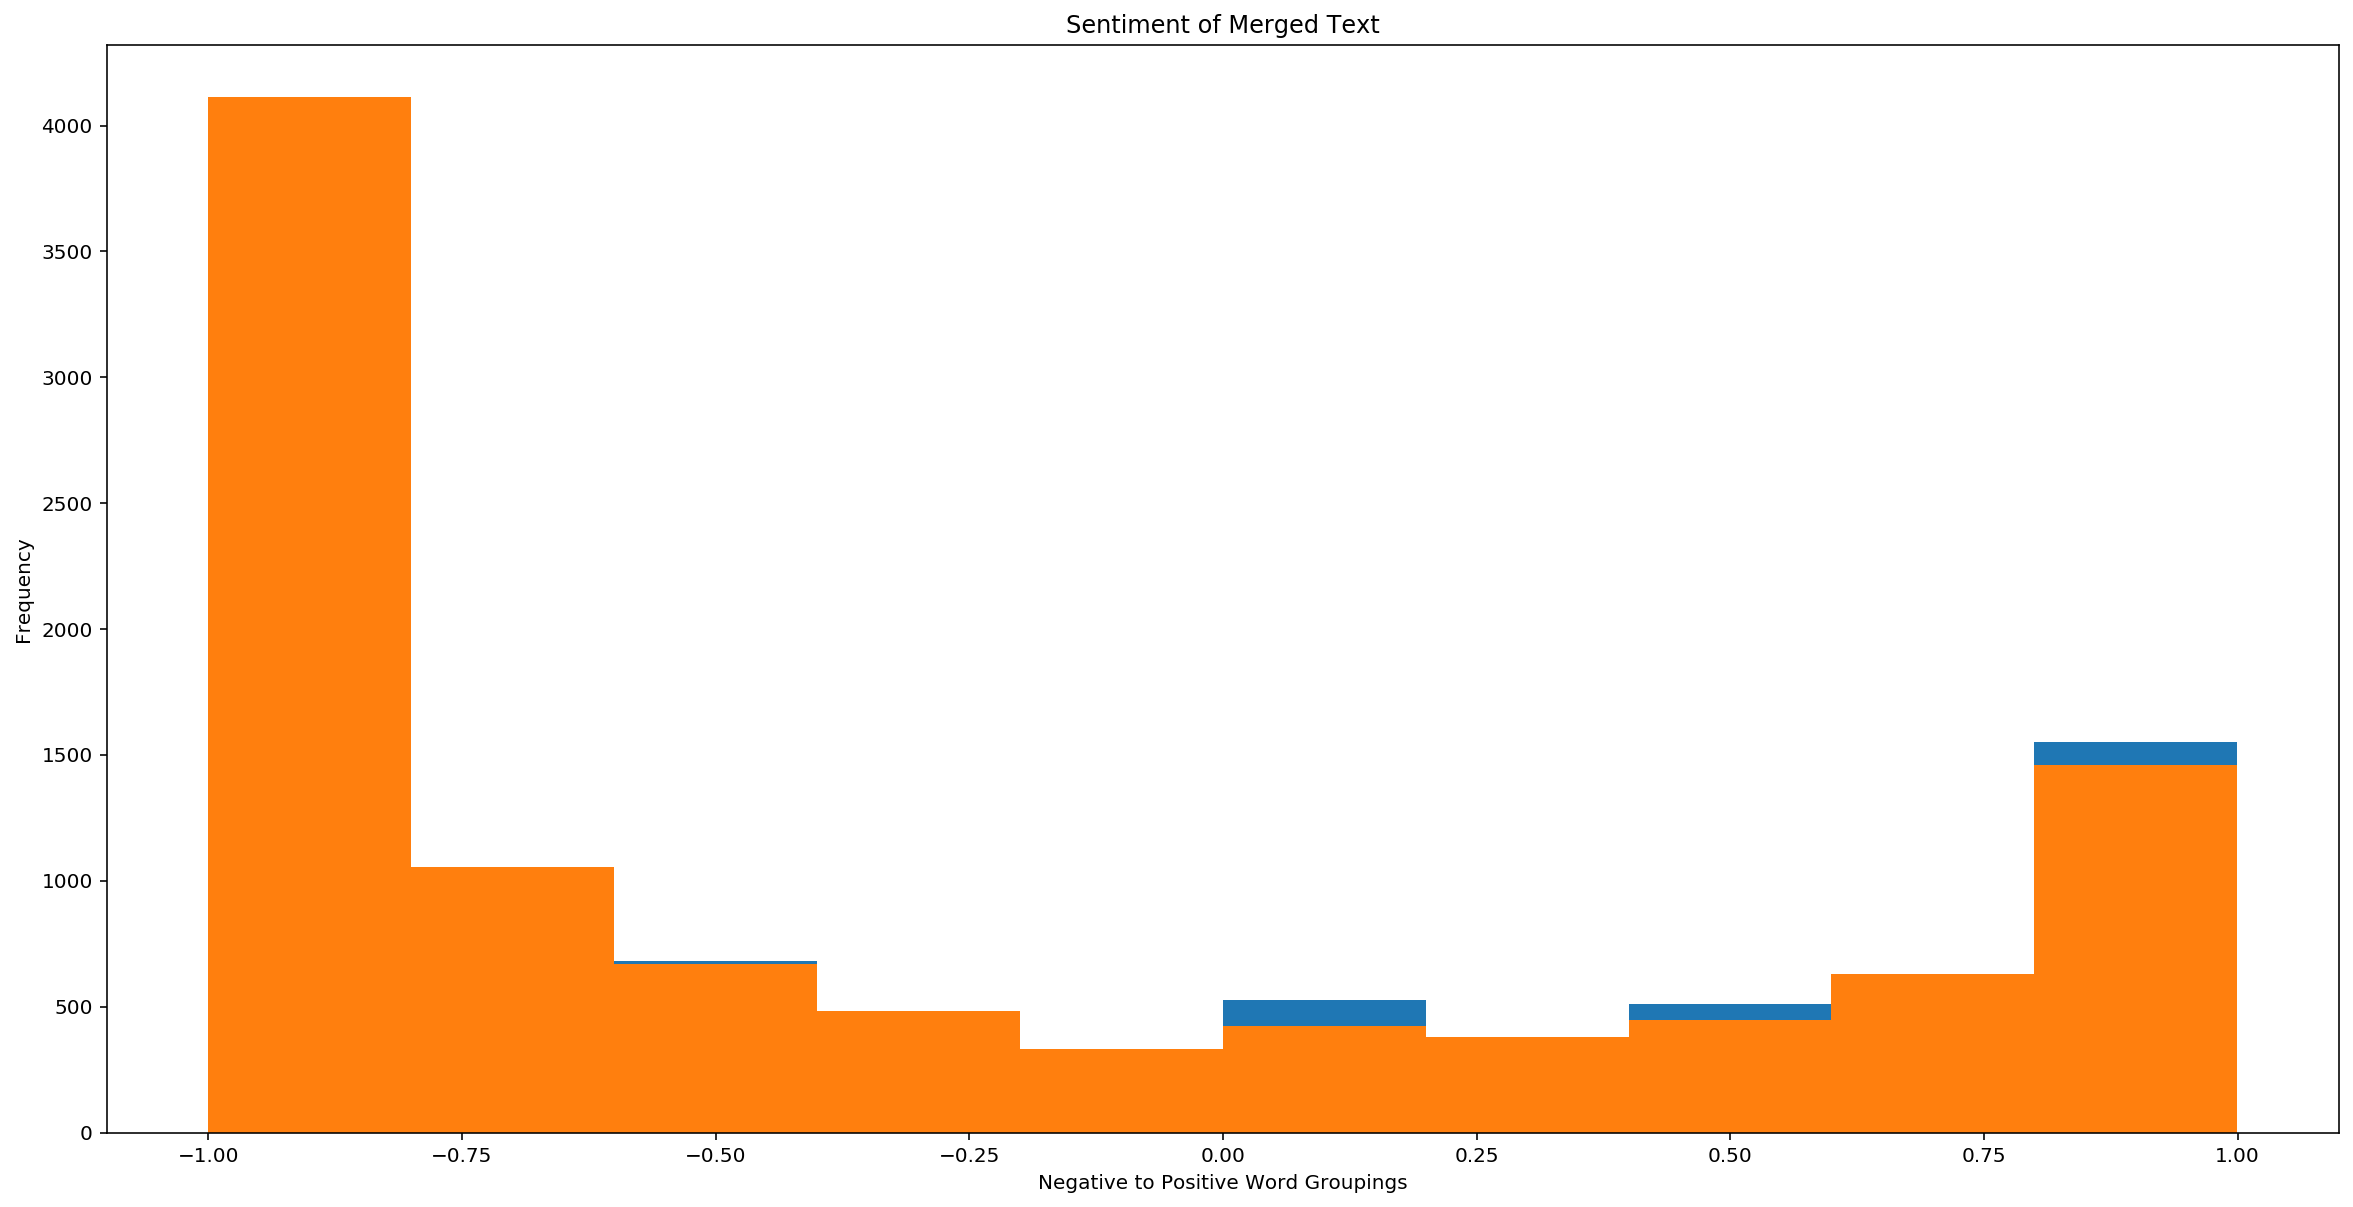

In [22]:
plt.figure(figsize=(20,10))
term_df.groupby('target_sub')['merged_sentiment'].plot(kind = 'hist');
plt.title(label="Sentiment of Merged Text");
plt.xlabel('Negative to Positive Word Groupings');

These simply show a lot of overlap and are not extremely informative. Let's try a different graph.

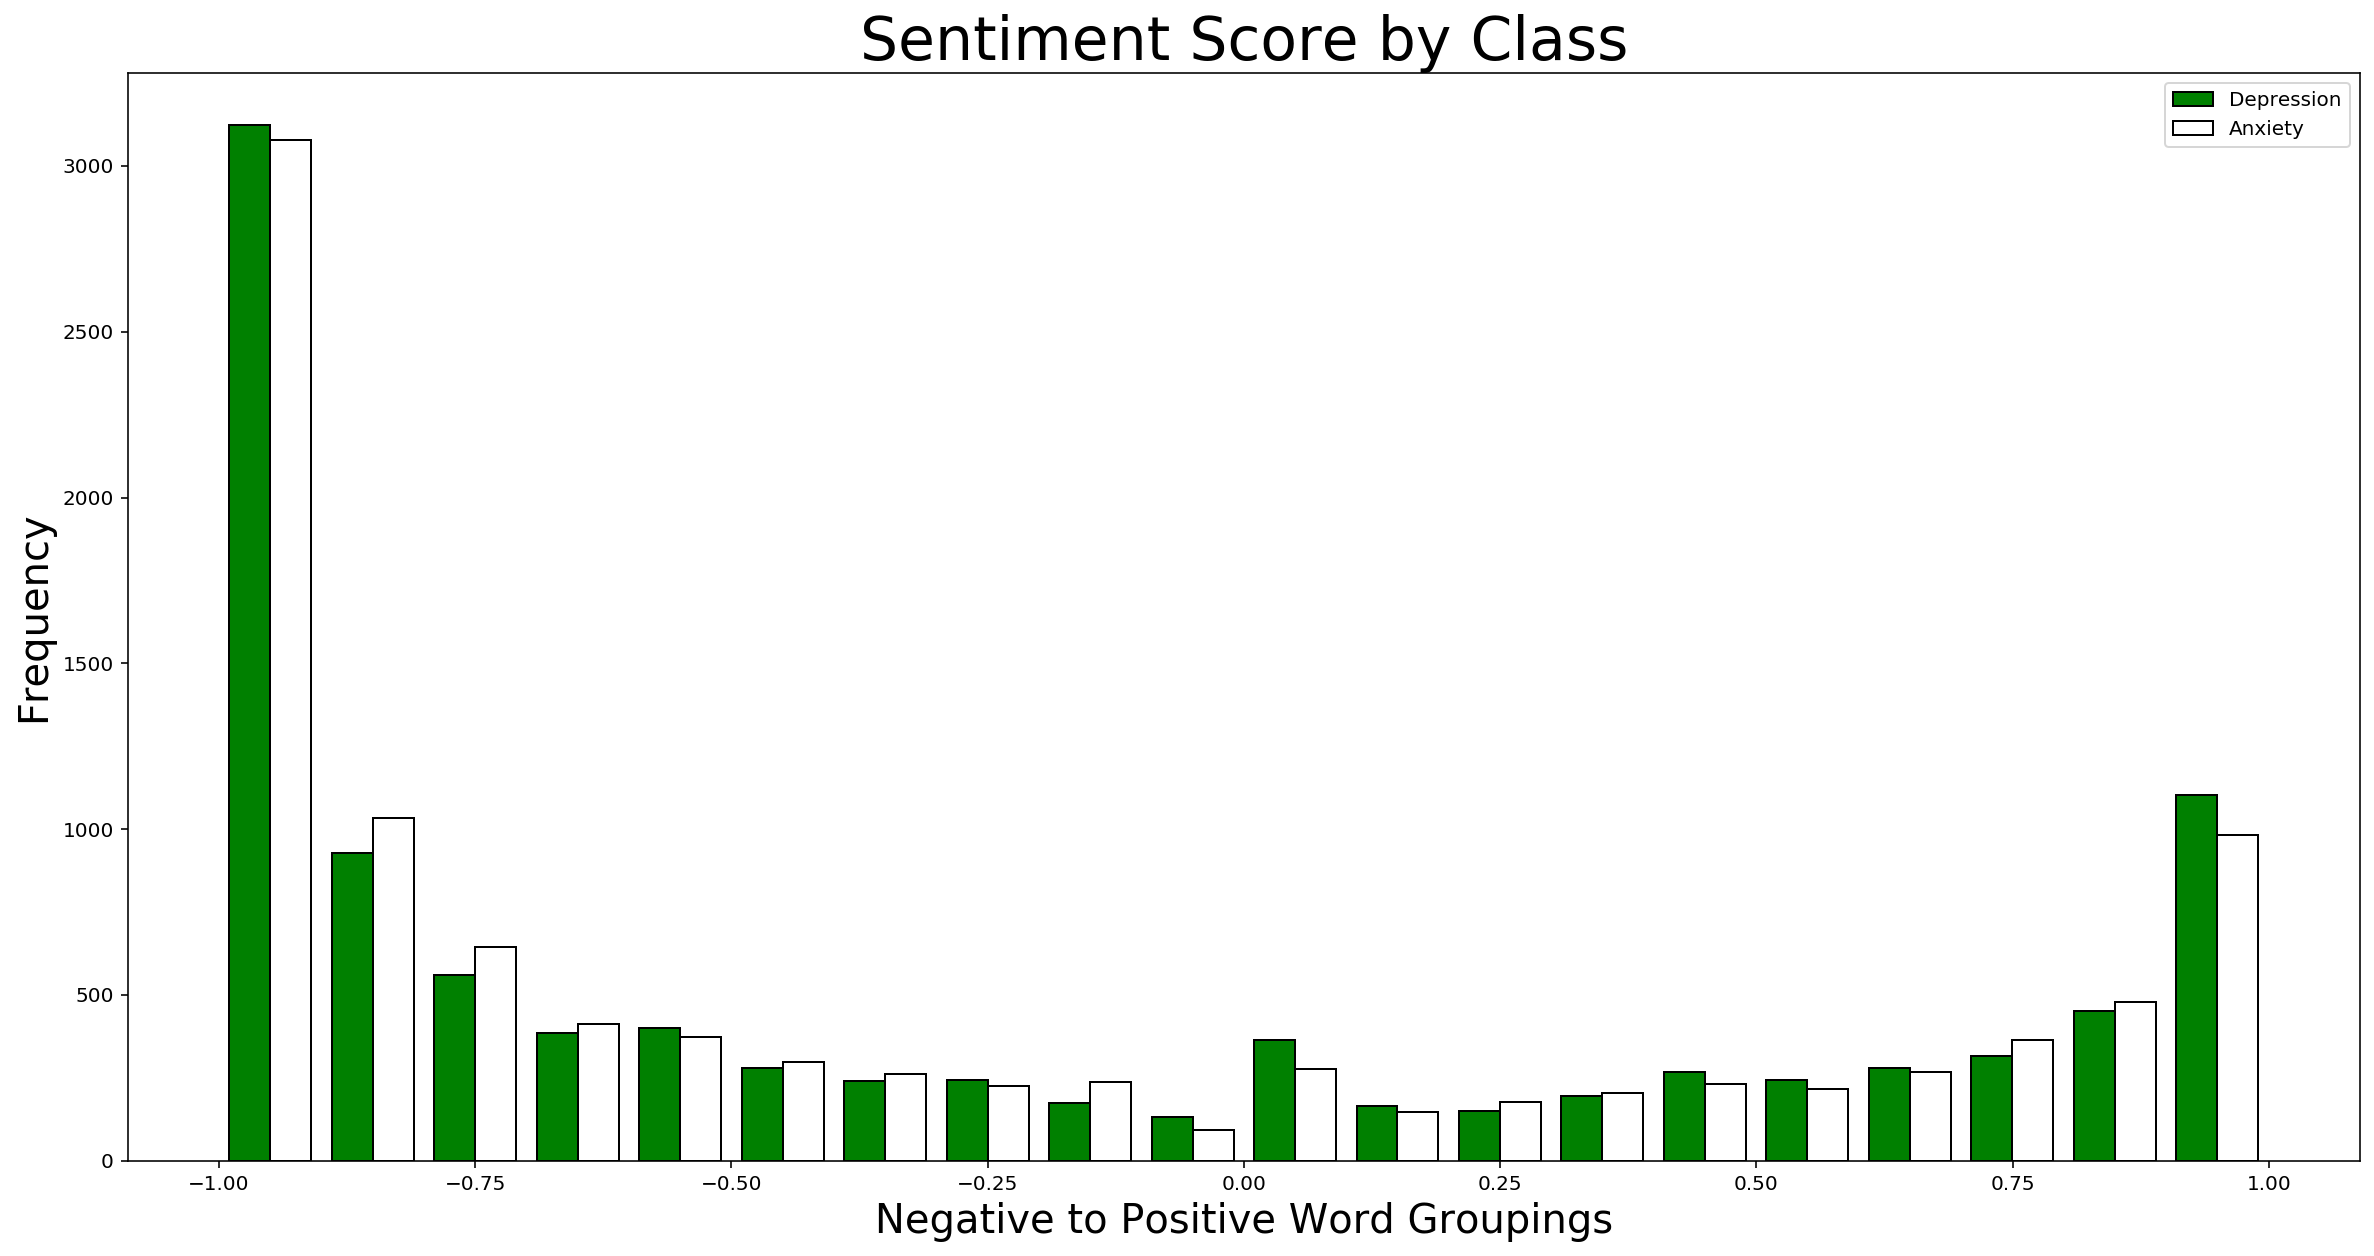

In [23]:
plt.figure(figsize=(20,10))
plt.hist([term_df[term_df['target_sub']==0]['merged_sentiment'], 
          term_df[term_df['target_sub']==1]['merged_sentiment']],
         bins=20, color=['green', 'white'], ec='k')
plt.title('Sentiment Score by Class', fontsize=30)
plt.xlabel('Negative to Positive Word Groupings', fontsize=20)
plt.ylabel('Frequency', fontsize= 20)
plt.legend(['Depression', 'Anxiety']);
plt.savefig('./assets/sentiment_score.png')

Because we have that word count data. Let's graph the word counts by class

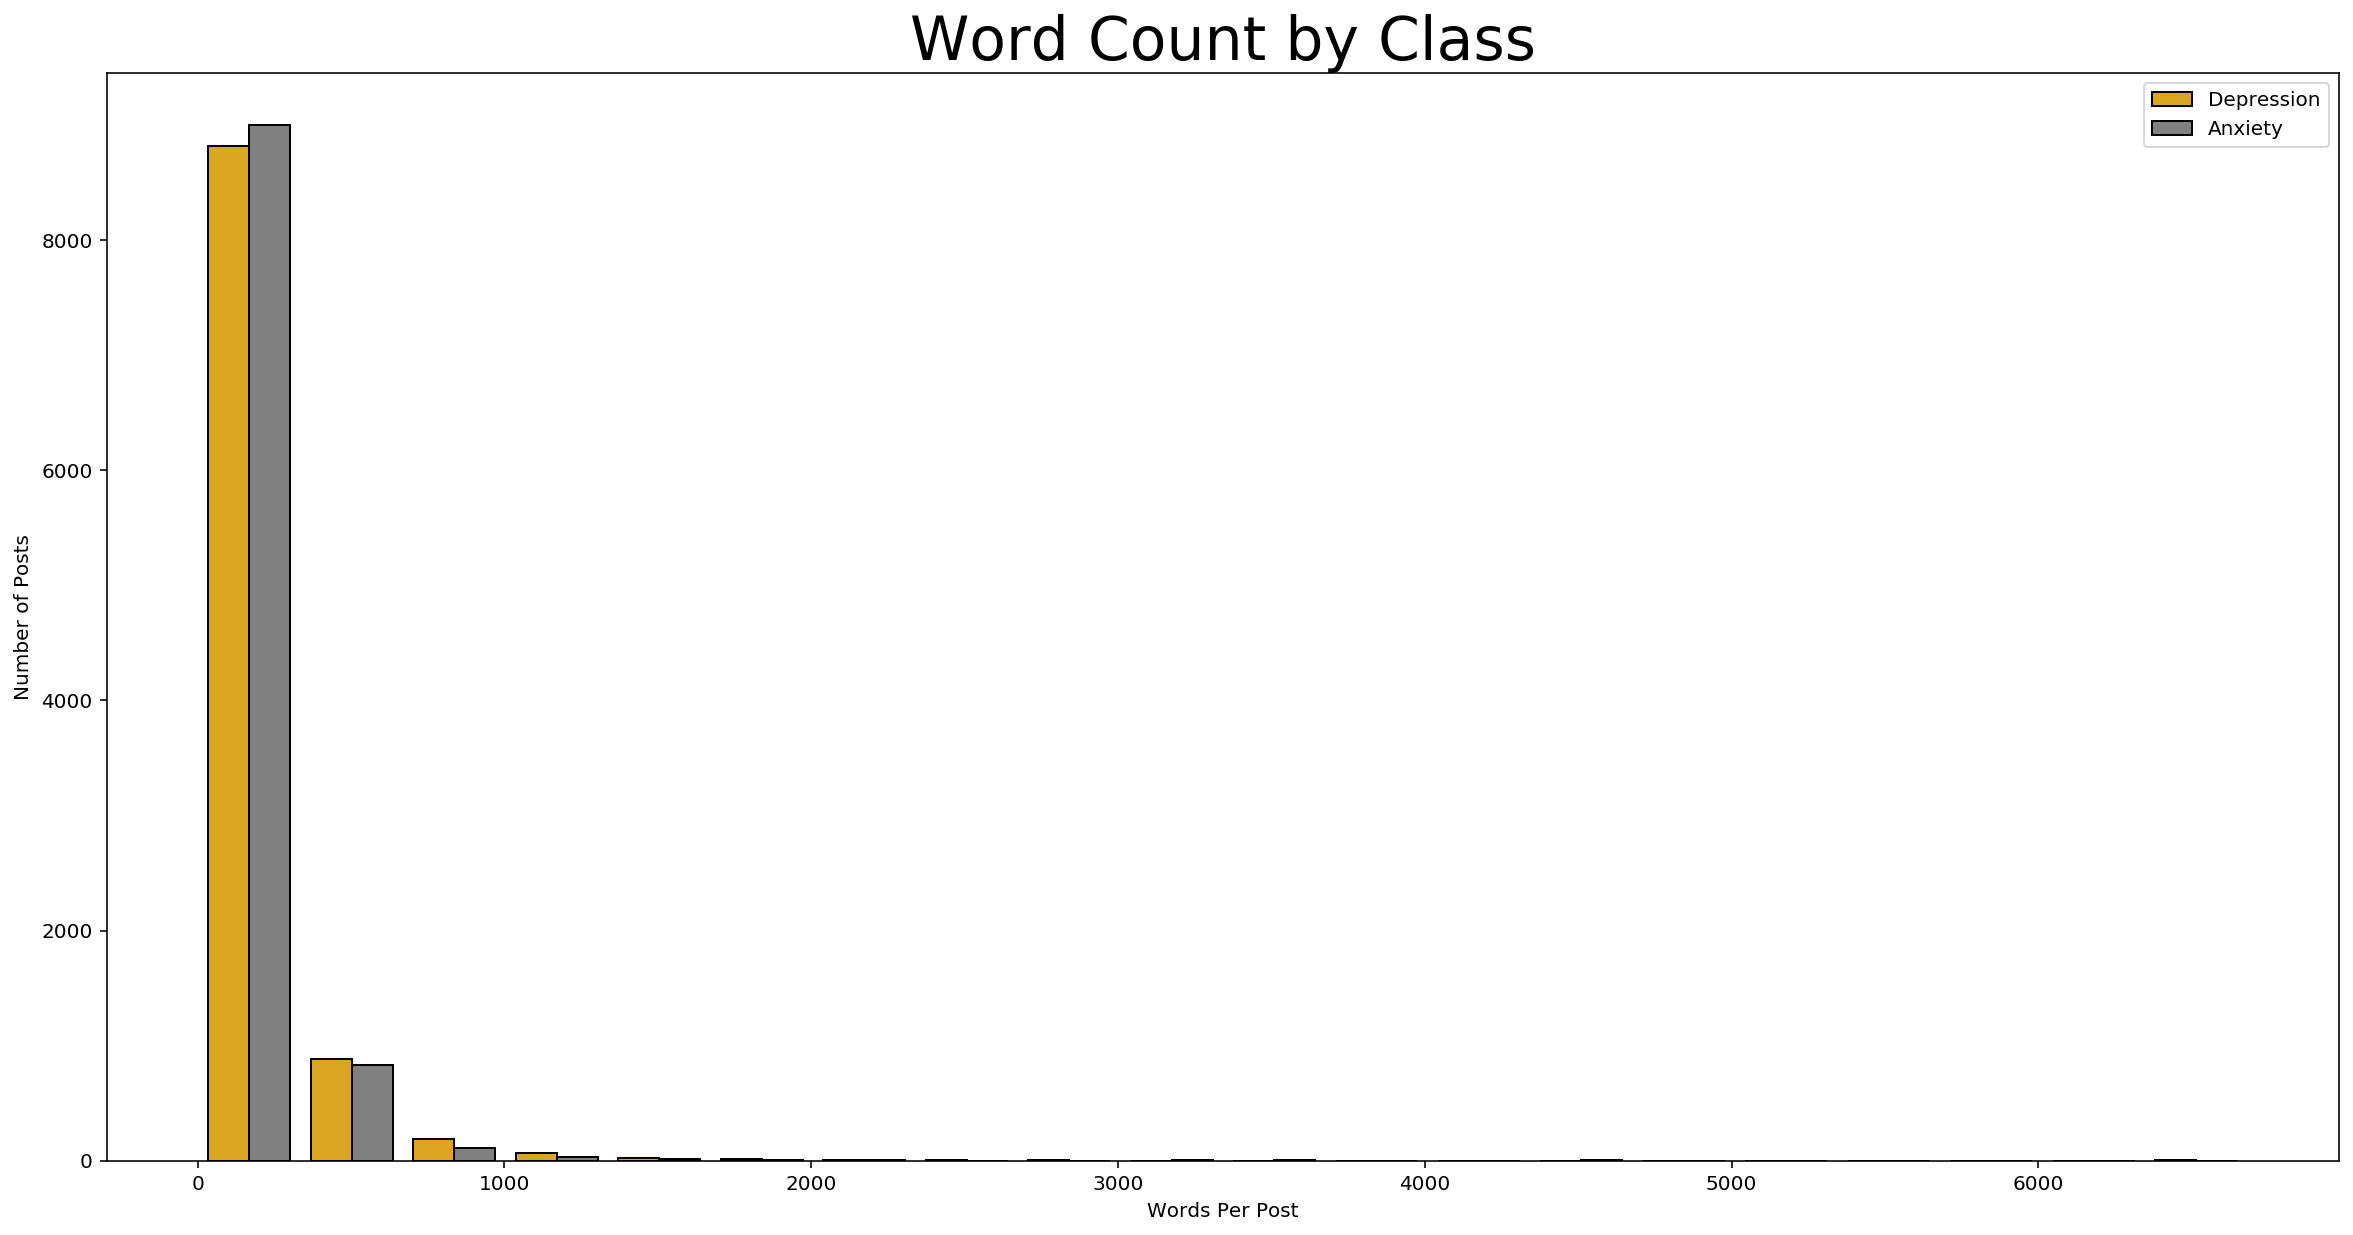

In [112]:
plt.figure(figsize=(20,10))
plt.hist([term_df[term_df['target_sub']==0]['word_count'], 
          term_df[term_df['target_sub']==1]['word_count']],
         bins=20, color=['goldenrod', 'grey'], ec='k')
plt.title('Word Count by Class', fontsize=30)
plt.legend(['Depression', 'Anxiety']);
plt.xlabel('Words Per Post')
plt.ylabel("Number of Posts")
plt.savefig('./assets/word_count_by_class.png')

In [25]:
top_words_overlap = [post for post in top_words_anxiety if post in top_words_depression]

Added a list of 83 common medication and generic names pulled from previous experience in the field and saved it as a `med_list`. After that, I made sure to run a list comprehenstion so that all words were formatted as lowercase. 

In [26]:
med_list = ['alprazolam', 'amoxapine',
            'aripiprazole', 'buspirone',
            'chloriazepoxide', 'clozapine',
            'citalopram', 'hydrobromide',
            'clonazepam', 'amitriptyline',
            'amphetamine', 'buproprion',
            'carbamazepine', 'chlorpromazine',
            'clomipramine', 'clorazepate',
            'desipramine', 'diazepam',
            'doxepin', 'fluoxetine',
            'fluvoxamine', 'imipramine',
            'lithium', 'citrate',
            'loxapine', 'mesoridazine',
            'mirtazapine', 'nefazodone',
            'olanzapine', 'paroxetine',
            'perphenazine', 'prazepam',
            'protriptyline', 'risperidone',
            'thioridazine', 'tranylcypromine',
            'sulfate', 'trifluoperazine ',
            'trimipramine', 'Surmontil',
            'venlafaxine', 'Effexor',
            'tricyclic', 'valproic',
            'Xanax', 'Asendin',
            'Abilify', 'BuSpar',
            'Librium', 'Celexa',
            'Klonopin', 'Clozaril',
            'Elavil', 'Endep',
            'Adderall', 'Wellbutrin',
            'Tegretol', 'Thorazine',
            'Anafranil', 'Tranxene',
            'Norpramin', 'Valium',
            'Adapin', 'Sinequan',
            'Prozac', 'Luvox',
            'Tofranil', 'Cibalith',
            'Loxitane', 'Serentil',
            'Remeron', 'Serzone',
            'Zyprexa', 'Paxil',
            'Trilafon', 'Centrax',
            'Vivactil', 'Risperdal',
            'Mellaril', 'Prarnate',
            'Stelazine', 'Vesprin', 'Depakene ']

med_list = [i.lower() for i in med_list]

Next I will grab a list of the all of the words that were pulled out of `df['merged_text']` by using the `.keys()` method on the tranformed dataframe, `term_df`.

In [27]:
keys_list = term_df.keys()
keys_list = [i.lower() for i in term_df.keys()]

We can now use a for loop to create a list of all the medications that were mentioned in `df['merged_text']`. We'll then go ahead and print out a sorted list and check it's length. 

In [28]:
meds_mentioned = []
for i in med_list:
    if i in keys_list:
        meds_mentioned.append(i)
meds_mentioned.sort()
print(f'''There were {len(meds_mentioned)} medications from the med_list mentioned in merged_text. 
      
They are as follows: {meds_mentioned}''')


There were 25 medications from the med_list mentioned in merged_text. 
      
They are as follows: ['abilify', 'adderall', 'alprazolam', 'amitriptyline', 'buspar', 'buspirone', 'celexa', 'citalopram', 'clonazepam', 'diazepam', 'effexor', 'fluoxetine', 'klonopin', 'lithium', 'luvox', 'mirtazapine', 'paroxetine', 'paxil', 'prozac', 'risperdal', 'valium', 'venlafaxine', 'wellbutrin', 'xanax', 'zyprexa']


Let's take this information, turn it into some usable variables and see what information we can glean from occurances of these medications in posts

In [29]:
depression = term_df[term_df['target_sub']==0][meds_mentioned].sum()
anxiety = term_df[term_df['target_sub']==1][meds_mentioned].sum()

In [30]:
depression.sort_index(inplace=True)

In [31]:
len(depression.values)

25

In [32]:
anxiety.sort_index(inplace=True)

In [33]:
anxiety.values

array([  8,  31,   7,   7,  67,  50,  31,  45,  35,  19,  55,  28,  78,
         8,  10,  13,   8,  29, 106,   8,  24,  13,  54, 224,  19])

In [34]:
ad_df = pd.concat([pd.DataFrame(anxiety), pd.DataFrame(depression)], axis = 1)
ad_df.columns = ['anxiety', 'depression']
ad_df = ad_df.sort_values('depression', ascending = True)

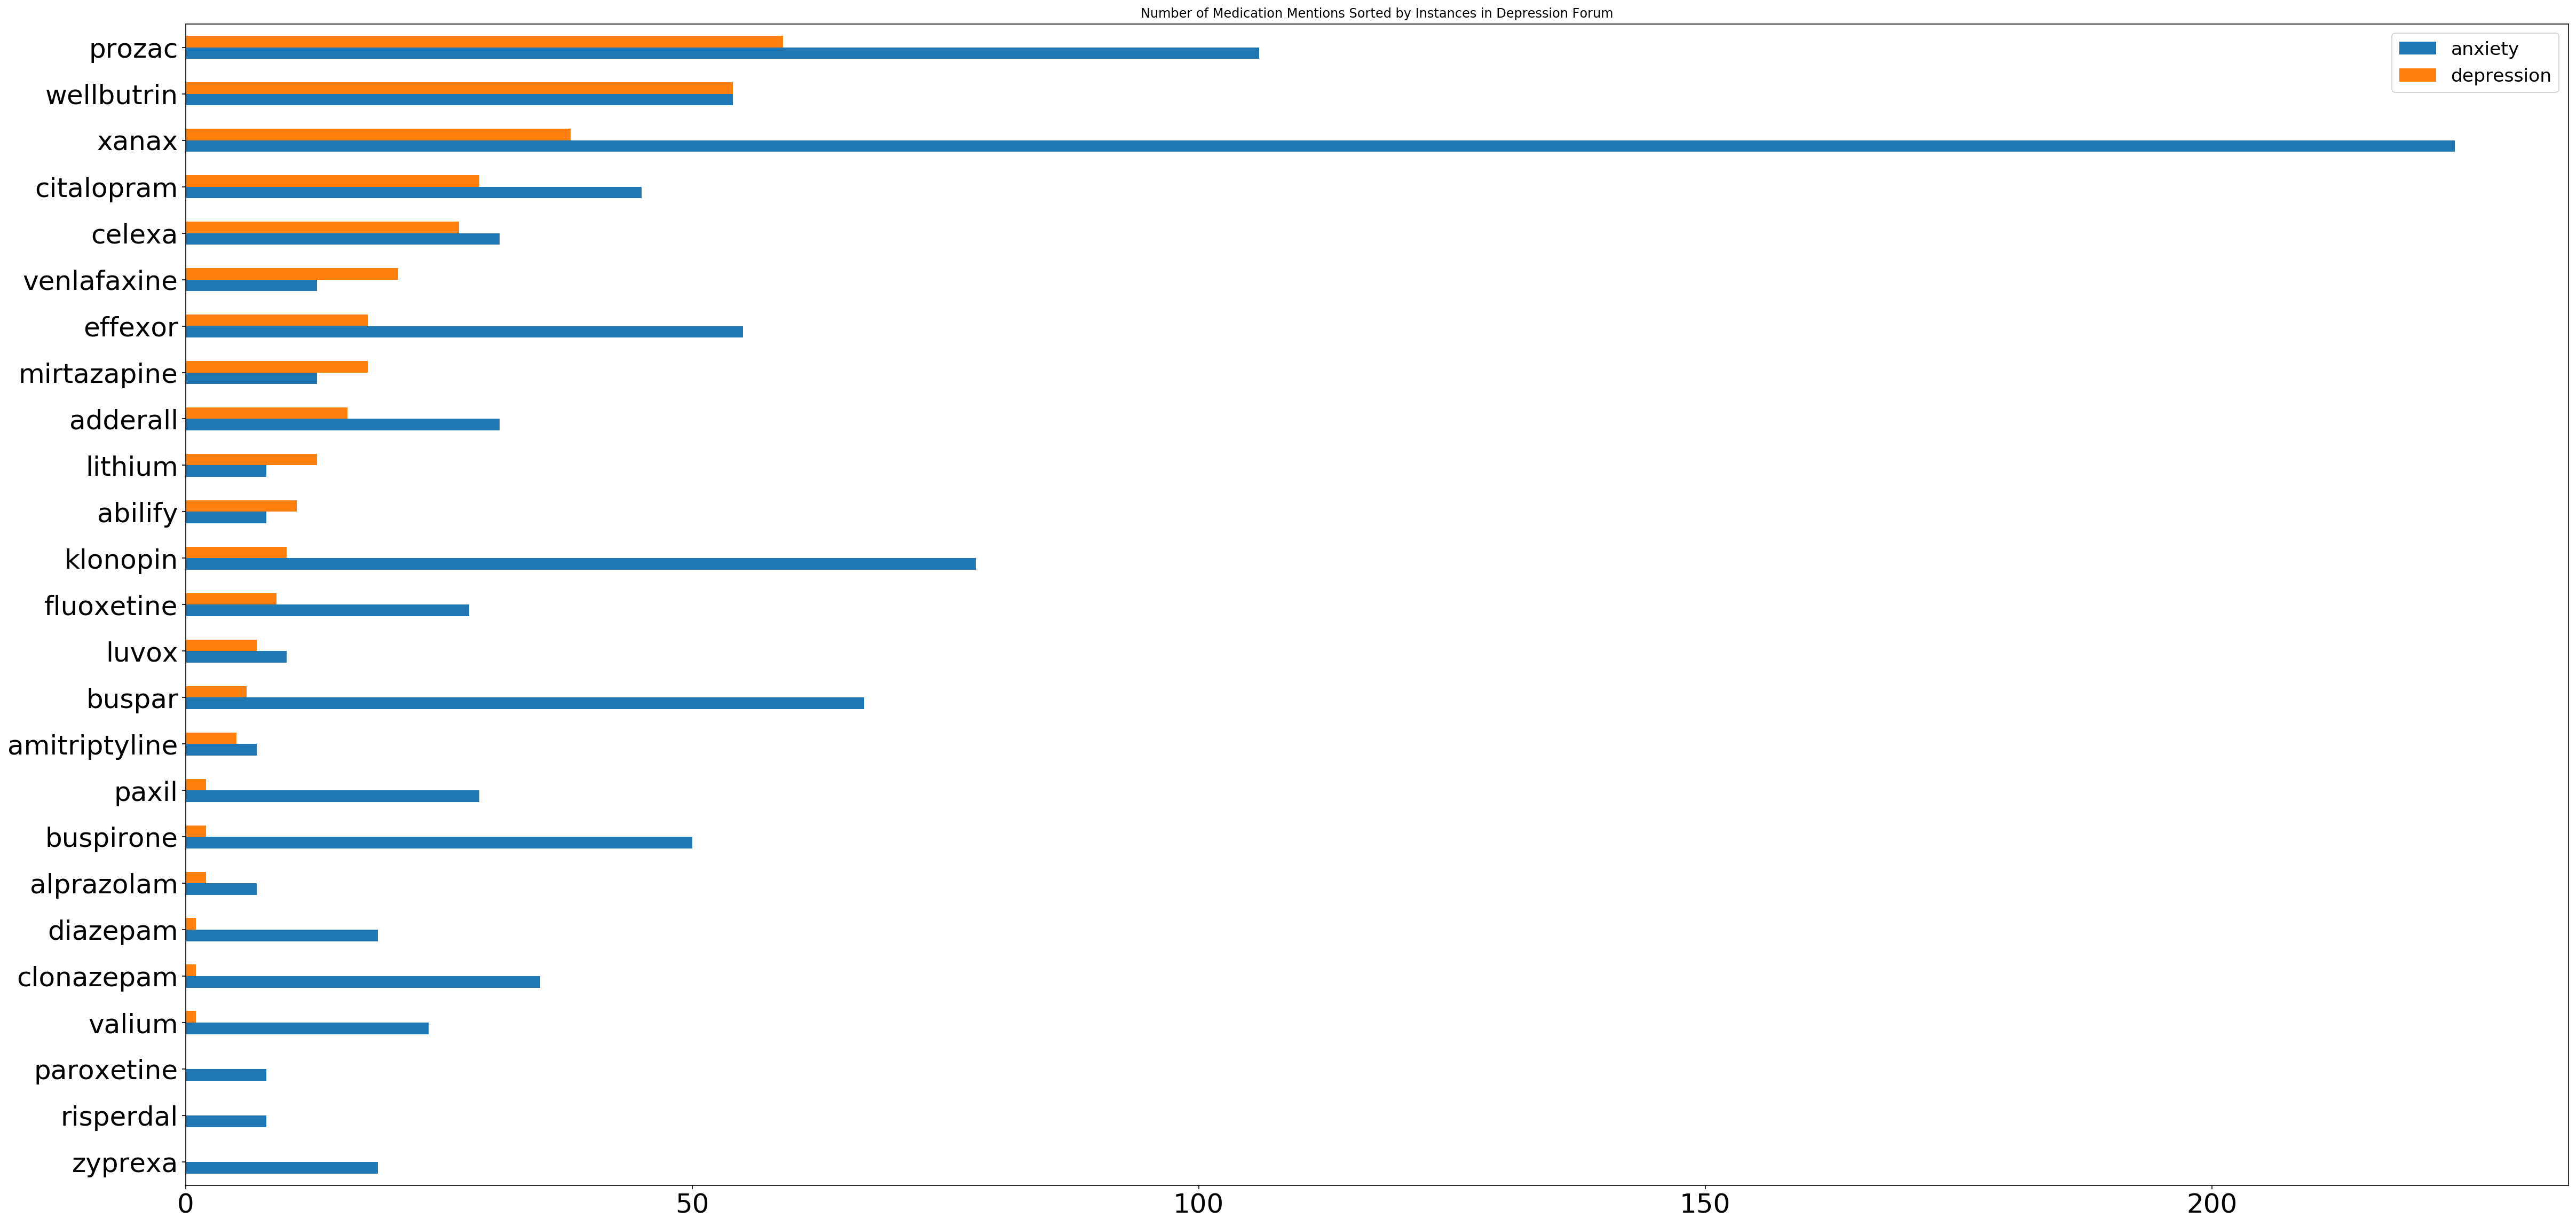

In [46]:
ax = ad_df.plot(kind = 'barh', figsize = (40,20), fontsize= 25, title = 'Number of Medication Mentions Sorted by Instances in Depression Forum');
ax.legend(fontsize='xx-large');
plt.savefig('./assets/med_chart_depression.png');

In [72]:
ad_df

,anxiety,depression
zyprexa,19,0
risperdal,8,0
paroxetine,8,0
valium,24,1
clonazepam,35,1
diazepam,19,1
alprazolam,7,2
buspirone,50,2
paxil,29,2
amitriptyline,7,5


In [37]:
print(f'''Top words for anxiety are as follows: {top_words_anxiety}.

Top words for depression are as follows: {top_words_depression}.

Finally, the top words for both anxiety and depression are as follows: {top_words_overlap}.''')
      

Top words for anxiety are as follows: ['anyone', 'anxious', 'work', 'panic', 'feeling', 'bad', 'got', 'also', 'always', 'never', 'still', 'need', 'could', 'else', 'make', 'since', 'year', 'last', 'started', 'anything', 'job', 'getting', 'good', 'friends', 'way', 'every', 'attack', 'first', 'someone', 'lot'].

Top words for depression are as follows: ['never', 'friends', 'always', 'anything', 'good', 'everything', 'better', 'make', 'work', 'still', 'school', 'could', 'got', 'someone', 'anymore', 'feeling', 'nothing', 'way', 'anyone', 'depressed', 'every', 'see', 'need', 'talk', 'bad', 'happy', 'hate', 'year', 'fucking', 'love'].

Finally, the top words for both anxiety and depression are as follows: ['anyone', 'work', 'feeling', 'bad', 'got', 'always', 'never', 'still', 'need', 'could', 'make', 'year', 'anything', 'good', 'friends', 'way', 'every', 'someone'].


In [88]:
print(depression.head())

abilify          11
adderall         16
alprazolam        2
amitriptyline     5
buspar            6
dtype: int64
